# Plant Disease Detection

## Import liberaries and models

In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model 
from tensorflow.keras.applications.inception_v3 import InceptionV3 
from tensorflow.keras.applications.inception_v3 import preprocess_input 
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img 
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras import models 
from tensorflow.keras import layers 
from sklearn.model_selection import train_test_split
import tensorflow as tf 
import os
import numpy as np
import glob 
import matplotlib.pyplot as plt 
from keras.models import load_model

## Get the Data

In [2]:
imageSize = 224
batchSize = 20

In [3]:
dataSet = tf.keras.preprocessing.image_dataset_from_directory(
  "train2",
    shuffle = True, 
    image_size = (imageSize, imageSize),
    batch_size = batchSize
)

Found 5000 files belonging to 25 classes.


## Data Exploraion

In [4]:
Categories = dataSet.class_names
Categories

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [5]:
len(dataSet)

250

In [6]:
for image_batch, label_batch in dataSet.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(20, 224, 224, 3)
[ 6 22 23 21 13 12  2  7  0 12  9  8  4 17  0  6  4  1  4 11]


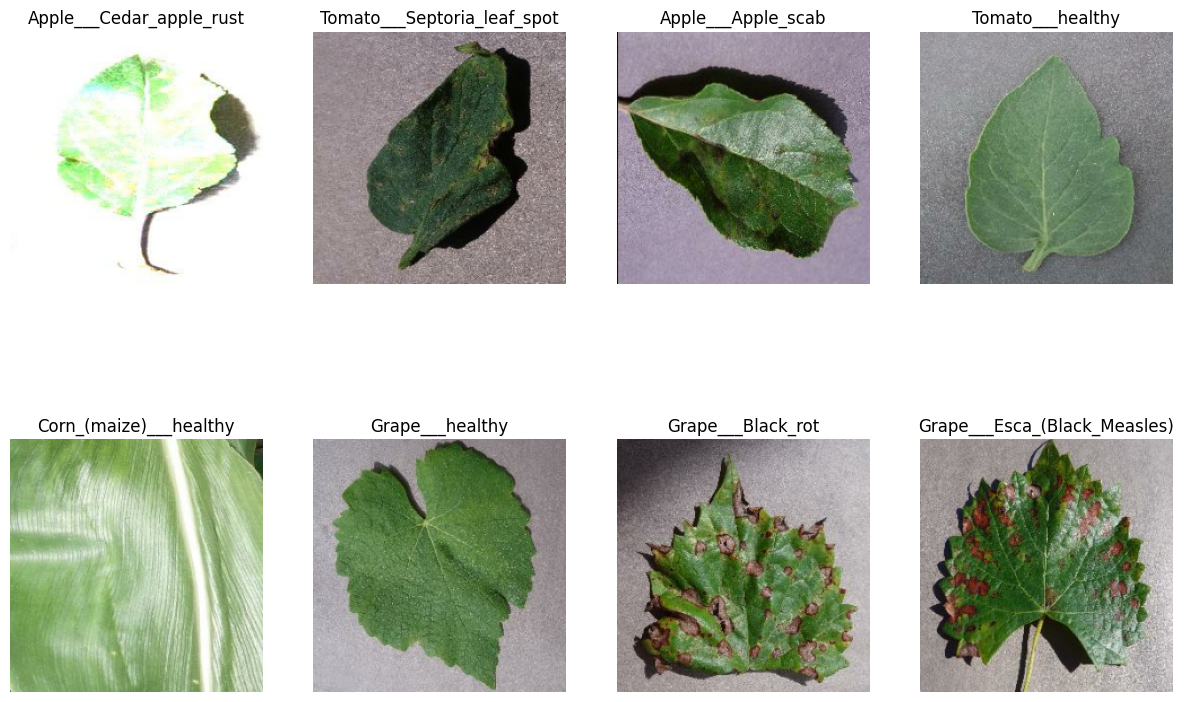

In [7]:
plt.figure(figsize=(15, 15))
for image_batch, label_batch in dataSet.take(2):
    for i in range(8):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) 
        plt.title(Categories[label_batch[i]])
        plt.axis("off")

In [14]:
def train_valid_split(dataset, train_split = 0.8, valid_split=0.2, shuffle=True, shuffle_size=10000):
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    
    n_train = train_split * len(dataset)
    train_data = dataset.take(int(n_train))
    valid_data = dataset.skip(int(n_train))

    print("Train size: ",len(train_data))
    print("Valid size: ", len(valid_data))
    return train_data, valid_data

In [15]:
trainSet, validSet = train_valid_split(dataSet)

Train size:  200
Valid size:  50


In [16]:
trainSet = trainSet.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validSet = validSet.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## MobileNet

In [21]:
rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(imageSize, imageSize),
    layers.experimental.preprocessing.Rescaling(1.0/imageSize)
])

AttributeError: module 'tensorflow.keras.layers' has no attribute 'experimental'

In [17]:
inputShape=(batchSize, imageSize, imageSize,3)

In [2]:
import tensorflow_hub as hub
from tensorflow_hub import KerasLayer
mobileNet = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

In [11]:
nClasses = len(Categories)

with CustomObjectScope({'KerasLayer': tf.keras.layers.Layer}):
    model =models.Sequential([
    rescale,
    tf.keras.layers.InputLayer(input_shape=inputShape, dtype=tf.float32),
    KerasLayer(mobileNet,trainable=False,dtype=tf.float32),
    Flatten(),
    Dense(1024,activation='relu'),
    Dense(512,activation='relu'),
    Dense(256,activation='relu'),
    Dense(nClasses,activation='softmax')
])

NameError: name 'rescale' is not defined

In [32]:
model.build(inputShape)

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (20, 224, 224, 3)         0         
                                                                 
 input_3 (InputLayer)        multiple                  0         
                                                                 
 keras_layer (KerasLayer)    (20, 1280)                2257984   
                                                                 
 flatten (Flatten)           (20, 1280)                0         
                                                                 
 dense (Dense)               (20, 1024)                1311744   
                                                                 
 dense_1 (Dense)             (20, 512)                 524800    
                                                                 
 dense_2 (Dense)             (20, 256)                

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
n_epochs = 20

history = model.fit(
    trainSet,
    epochs = n_epochs, 
    batch_size = batchSize,
    verbose=1,
    validation_data=validSet
)

Epoch 1/20
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x000002262339F4C0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x000002262339F4C0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x000002262339F4C0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


KeyboardInterrupt: 

In [ ]:
def draw_acc_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  #Train and validation accuracy
  plt.plot(epochs, acc, 'b', label='Training accurarcy')
  plt.plot(epochs, val_acc, 'g', label='Validation accurarcy')
  plt.title('Training and Validation accurarcy')
  plt.legend()
  plt.figure()
  #Train and validation loss
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title('Training and Validation loss')
  plt.legend()
    
  plt.show()

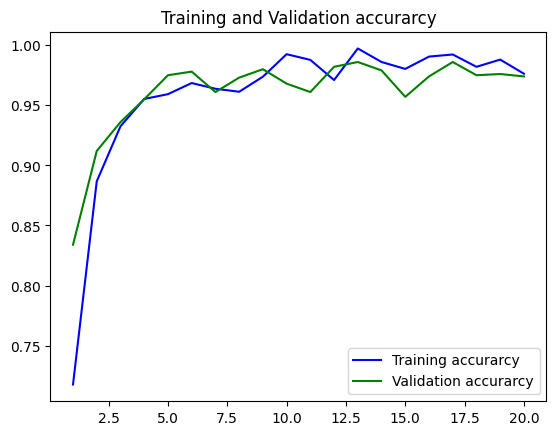

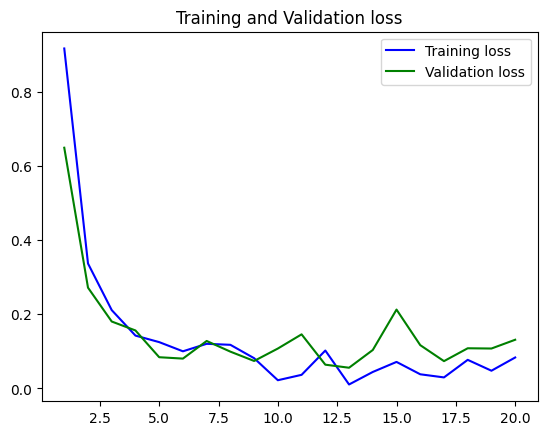

In [25]:
draw_acc_loss(history)

In [9]:
model.save('PlantDetectionModal.h5')

NameError: name 'model' is not defined

In [3]:
model = tf.keras.models.load_model('PlantDetectionModal.h5', 
 custom_objects={'KerasLayer':hub.KerasLayer}
)

TypeError: Error when deserializing class 'KerasLayer' using config={'name': 'keras_layer', 'trainable': False, 'dtype': 'float32', 'handle': 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'}.

Exception encountered: Trying to load a model of incompatible/unknown type. 'C:\Users\User\AppData\Local\Temp\tfhub_modules\145bb06ec3b59b08fb564ab752bd5aa222bfb50a' contains neither 'saved_model.pb' nor 'saved_model.pbtxt'.

## Testing

In [16]:
imagePath = "corn-leaves.jpg"
img = image.load_img(imagePath, target_size=(224, 224))
imageArray = image.img_to_array(img)
imageArray = np.expand_dims(imageArray, axis=0)


# Make a prediction
prediction = model.predict(imageArray)

# Print the predicted class
categories = Categories
predicted_class = np.argmax(prediction)
print(categories[predicted_class])

1/1 [==============================] - 0s 62ms/step
Corn_(maize)___healthy
